In [1]:
import gzip
import numpy as np
import scipy.stats as SSA
import torch
from torch_geometric.data import Data,DataLoader
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
Rtx = np.loadtxt('Rtx_p_synthetic.csv') ## = Rtx_2 = np.loadtxt('Rtx_synthetic.csv')
# Rtx = np.loadtxt('Rtx_d_synthetic.csv')
# Rtx = np.loadtxt('Rtx_d_log_synthetic.csv')

In [3]:
def load_gzipped_numpy(filename):
    try:
        with gzip.open(filename, 'rb') as f:
            return np.load(f, allow_pickle=True)
    except FileNotFoundError:
        return [0]

In [43]:
r_dispersion = 0.025
g_idx = 1
sub_export_dir = '/Users/qing/Library/CloudStorage/OneDrive-ColumbiaUniversityIrvingMedicalCenter/0_branching_model_review/codes/branching_r-{}/'.format(r_dispersion)
export_names = sub_export_dir+'NewInf_r-{}_{}.npy.gz'.format(np.round(r_dispersion,3),(g_idx))
g_i = load_gzipped_numpy(export_names)
# np.savetxt('simulation_r-{}'.format(r),g_i,delimiter=",")
infections = np.sum(g_i,axis=0)
# np.savetxt('sum_simulation_r-{}.csv'.format(r),infections,delimiter=",")

In [44]:
np.sum(infections) ### make sure there is a correct file 

1638711.0

In [45]:
# Python to R
%load_ext rpy2.ipython
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.conversion import localconverter


inc = pd.Series(infections,name="incid")
with localconverter(pandas2ri.converter):
    r_infections = pandas2ri.py2rpy(inc)

# Assign the R object to R's global environment
r.assign("inc", r_infections)
r.assign("r", r_dispersion)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


0.025000


In [46]:
%%R
# This code runs in R
# require(testthat)

# Infer the Rt using EpiEstim in R pacakages if not installed
# install.packages("lubridate")
# install.packages("dplyr")
# install.packages("zoo")
# install.packages("EpiEstim")

library('lubridate')
library('zoo')
library('dplyr')
library('EpiEstim')
library('tidyr')
library(ggplot2)

In [47]:
%%R 
### for a single inc
mean_si <- 5.5
std_si <- 2.5
window_size <- 7  # can be adjusted

n_days <- length(inc)
# # Define sliding window
t_start <- seq(2, n_days - window_size+1)
t_end <- t_start + window_size - 1

result <- estimate_R(
  incid = inc,
  method = "parametric_si",
  config = make_config(list(
    mean_si = mean_si,
    std_si = std_si,
    t_start = t_start,
    t_end = t_end
  ))
)



In [48]:
res_R = r('result$R')  # res must already be defined in R

# Convert R data.frame to pandas DataFrame
with localconverter(pandas2ri.converter):
    res_R_df = pandas2ri.rpy2py(res_R)

# Assume res_R_df is the DataFrame you showed
res_R_df.columns = res_R_df.columns.str.replace(r'\(R\)', '', regex=True).str.replace('.', '_')  # clean column names

# Initialize an empty list
daily_records = []

# Loop through each row
for _, row in res_R_df.iterrows():
    for t in range(int(row['t_start']), int(row['t_end']) + 1):
        daily_records.append({'day': t, 'Rt': row['Median']})

# Create a new DataFrame
daily_Rt = pd.DataFrame(daily_records)

# Optional: average if a day appears in multiple windows
daily_Rt = daily_Rt.groupby('day').mean().reset_index()
# start_date = pd.to_datetime("2020-02-22")
# daily_Rt['date'] = start_date + pd.to_timedelta(daily_Rt['day'] - 2, unit='D')

Text(0.5, 1.0, 'idx=1')

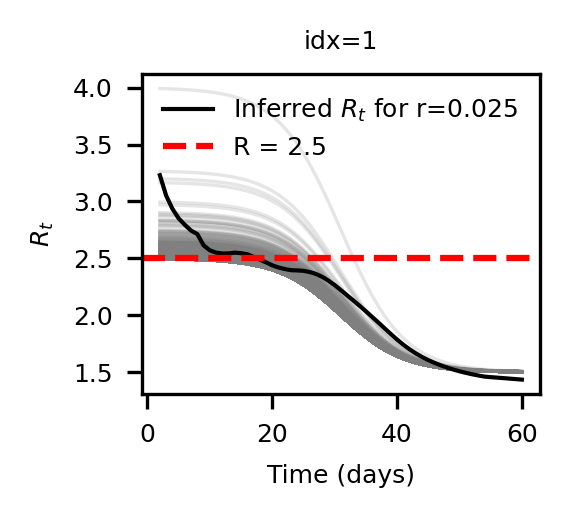

In [49]:
plt.figure(figsize=(2, 1.68), dpi=300) ## was (1.5,1.3) 2, 1.68
# Plot all ensemble Rtx curves
for i in range(3142):
    plt.plot(range(2, 61), Rtx[1:, i], alpha=0.2, lw=0.8, color="grey")

# Plot inferred Rt
plt.plot(
    daily_Rt['day'], daily_Rt['Rt'],
    label=f"Inferred $R_t$ for r={r_dispersion}",   # 
    color='black', linewidth=1
)

# Reference line at R=2.5
plt.axhline(2.5, color='red', linestyle='--', label='R = 2.5')

# Labels and title
plt.xlabel('Time (days)', fontsize=6)
plt.ylabel('$R_t$', fontsize=6)
# plt.title('Estimated vs Ensemble $R_t$', fontsize=14)

# Grid and legend
# plt.grid(alpha=0.3, linestyle='--')
plt.legend(frameon=False, fontsize=6)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
# plt.show()
plt.title('idx={}'.format(g_idx), fontsize=6)
# plt.savefig('../results/Rtx/Rtx_pop_infer/Rt_inferred_r-{}.png'.format(r_dispersion), dpi=300) #example_

In [539]:

Rt_temp = np.loadtxt('../test_nrr_output_pop/infered_Rtx/Rt_array_r-{}.csv'.format(r_dispersion))


In [50]:
daily_Rt.loc[-1] = [1, daily_Rt.loc[0, 'Rt']]  # copy value from row 0
daily_Rt.index = daily_Rt.index + 1  # shift index
daily_Rt = daily_Rt.sort_index().reset_index(drop=True)
# assert daily_Rt.shape[0] == 60, "Expected 60 days"
Rt_array = np.tile(daily_Rt['Rt'].values.reshape(-1, 1), (1, 3142))
np.savetxt('../test_nrr_output_pop/infered_Rtx/Rt_array_r-{}_{}.csv'.format(r_dispersion,g_idx), Rt_array)

In [236]:
### real observed reporting rates

In [544]:
infectin_real =  pd.read_csv('../data/EstimatedDailyInfection.csv')

In [23]:
infectin_real.head()

,County,FIPS,Date,2.5prctile,25prctile,50prctile,75prctile,97.5prctile
0,Autauga County AL,1001,02/21/2020,0,0,0,0,0
1,Autauga County AL,1001,02/22/2020,0,0,0,0,0
2,Autauga County AL,1001,02/23/2020,0,0,0,0,0
3,Autauga County AL,1001,02/24/2020,0,0,0,0,0
4,Autauga County AL,1001,02/25/2020,0,0,0,0,0


In [24]:
# Ensure Date is datetime type
infectin_real['Date'] = pd.to_datetime(infectin_real['Date'])
# Pivot the table: rows = FIPS, columns = Date, values = 50th percentile
pivot_df = infectin_real.pivot(index='FIPS', columns='Date', values='25prctile')
# Optional: sort columns (dates)
pivot_df = pivot_df.sort_index(axis=1)
# Convert to NumPy array
infection_array = pivot_df.to_numpy()

In [25]:
date_list = pivot_df.columns.to_list()[2:2+56]

In [26]:
np.sum(infection_array[:,3])

274

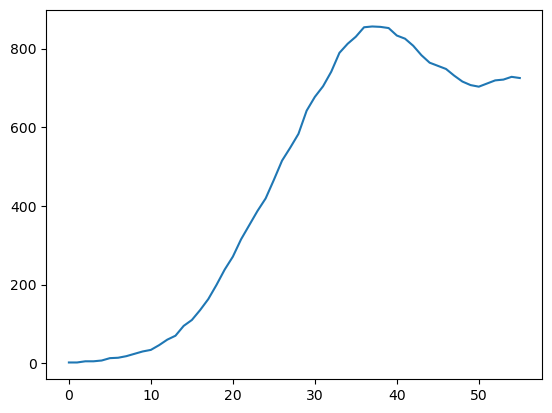

In [27]:
plt.plot(np.sum(infection_array[:,2:2+56]>10,axis=0))

In [28]:
#### make sure the FIPS idx match, can using the idx directly
real_fips = pivot_df.index.to_frame().reset_index(drop=True)
real_fips['real_idx'] = range(real_fips.shape[0])
simulated_fips = pd.read_csv('../data/fips_num.csv', header=None, names=['FIPS_simulation'])
simulated_fips['FIPS_simulation'] = simulated_fips['FIPS_simulation'].astype(int)
simulated_fips['simulation_idx'] = range(simulated_fips.shape[0])
fips_check = real_fips.merge(simulated_fips, left_on='FIPS', right_on='FIPS_simulation', how='left')
fips_check['idx_diff'] = fips_check['real_idx'] - fips_check['simulation_idx']
print(np.sum(fips_check['idx_diff']!=0), "FIPS idx do not match!")

0 FIPS idx do not match!


In [29]:
for t in range(10):
    has_inc = np.sum(infection_array[:,t]!=0)
    print(f"Day {t+1}: {has_inc} counties with non-zero infections")

Day 1: 1 counties with non-zero infections
Day 2: 2 counties with non-zero infections
Day 3: 3 counties with non-zero infections
Day 4: 3 counties with non-zero infections
Day 5: 7 counties with non-zero infections
Day 6: 13 counties with non-zero infections
Day 7: 18 counties with non-zero infections
Day 8: 21 counties with non-zero infections
Day 9: 28 counties with non-zero infections
Day 10: 36 counties with non-zero infections


In [30]:
seed_array = infection_array[:,2:4]
print(seed_array.shape) ### start from Feb 23, 2020 to match the mobility data
# np.savetxt('seed_real.csv', seed_array, delimiter=',')

(3142, 2)


In [31]:
temp = np.loadtxt('seed_real.csv', delimiter=',')
temp.shape

(3142, 2)

In [32]:
# np.save('real_inf',infection_array[:,2:70])
# infection_array[:,2:70].shape

In [33]:
np.sum(infection_array[:,70]==0)

1822

In [34]:
inc = pd.Series(np.sum(infection_array,axis=0),name="inc_real")
with localconverter(pandas2ri.converter):
    r_infections = pandas2ri.py2rpy(inc)
r.assign("inc_real", r_infections)

35,100,179,...,642322,639807,637010


In [37]:
%%R

mean_si <- 5.5
std_si <- 2.5
window_size <- 7  # can be adjusted
n_days <- 60 #length(inc_real)
# # Define sliding window
t_start <- seq(2, n_days - window_size+1)
t_end <- t_start + window_size - 1

result <- estimate_R(
  incid = inc_real,
  method = "parametric_si",
  config = make_config(list(
    mean_si = mean_si,
    std_si = std_si,
    t_start = t_start,
    t_end = t_end
  ))
)

# print(t_start)
# print(t_end)

In [45]:
previous = res_R_df['Median']

In [38]:
# Extract `res$R` from R
res_R = r('result$R')  # res must already be defined in R

# Convert R data.frame to pandas DataFrame
with localconverter(pandas2ri.converter):
    res_R_df = pandas2ri.rpy2py(res_R)

# Assume res_R_df is the DataFrame you showed
res_R_df.columns = res_R_df.columns.str.replace(r'\(R\)', '', regex=True).str.replace('.', '_')  # clean column names

# Initialize an empty list
daily_records = []

# Loop through each row
for _, row in res_R_df.iterrows():
    for t in range(int(row['t_start']), int(row['t_end']) + 1):
        daily_records.append({'day': t, 'Rt': row['Median']})

# Create a new DataFrame
daily_Rt = pd.DataFrame(daily_records)

# Optional: average if a day appears in multiple windows
daily_Rt = daily_Rt.groupby('day').mean().reset_index()
start_date = pd.to_datetime("2020-02-22")
daily_Rt['date'] = start_date + pd.to_timedelta(daily_Rt['day'] - 2, unit='D')

In [66]:
daily_Rt['day']

0      2
1      3
2      4
3      5
4      6
5      7
6      8
7      9
8     10
9     11
10    12
11    13
12    14
13    15
14    16
15    17
16    18
17    19
18    20
19    21
20    22
21    23
22    24
23    25
24    26
25    27
26    28
27    29
28    30
29    31
30    32
31    33
32    34
33    35
34    36
35    37
36    38
37    39
38    40
39    41
40    42
41    43
42    44
43    45
44    46
45    47
46    48
47    49
48    50
49    51
50    52
51    53
52    54
53    55
54    56
55    57
56    58
57    59
58    60
Name: day, dtype: int64

In [68]:
daily_Rt['date']

0    2020-02-22
1    2020-02-23
2    2020-02-24
3    2020-02-25
4    2020-02-26
5    2020-02-27
6    2020-02-28
7    2020-02-29
8    2020-03-01
9    2020-03-02
10   2020-03-03
11   2020-03-04
12   2020-03-05
13   2020-03-06
14   2020-03-07
15   2020-03-08
16   2020-03-09
17   2020-03-10
18   2020-03-11
19   2020-03-12
20   2020-03-13
21   2020-03-14
22   2020-03-15
23   2020-03-16
24   2020-03-17
25   2020-03-18
26   2020-03-19
27   2020-03-20
28   2020-03-21
29   2020-03-22
30   2020-03-23
31   2020-03-24
32   2020-03-25
33   2020-03-26
34   2020-03-27
35   2020-03-28
36   2020-03-29
37   2020-03-30
38   2020-03-31
39   2020-04-01
40   2020-04-02
41   2020-04-03
42   2020-04-04
43   2020-04-05
44   2020-04-06
45   2020-04-07
46   2020-04-08
47   2020-04-09
48   2020-04-10
49   2020-04-11
50   2020-04-12
51   2020-04-13
52   2020-04-14
53   2020-04-15
54   2020-04-16
55   2020-04-17
56   2020-04-18
57   2020-04-19
58   2020-04-20
Name: date, dtype: datetime64[ns]

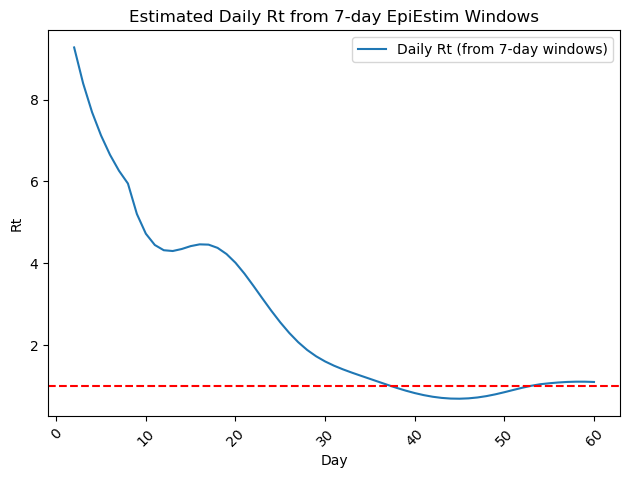

In [16]:

plt.plot(daily_Rt['day'], daily_Rt['Rt'], label='Daily Rt (from 7-day windows)')
# plt.plot(range(2,61), daily_Rt['Rt'], label='Daily smoonthing Rt (from 7-day windows)')
# plt.plot(range(8,61), previous.values, label='default sliding window end value', linestyle='--')
plt.axhline(y=1, color='red', linestyle='--')
plt.xlabel("Day")
plt.ylabel("Rt")
plt.title("Estimated Daily Rt from 7-day EpiEstim Windows")
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [35]:
len(daily_Rt['Rt'])

59

In [53]:
# Identify your time column (assumes it's the first column)
time_col = daily_Rt.columns[0]

first = daily_Rt.iloc[0].copy()
first[time_col] = 1  # set the day/t you want
daily_Rt_new = pd.concat([pd.DataFrame([first]), daily_Rt], ignore_index=True)

In [72]:
Rt_array_real = np.tile(daily_Rt_new['Rt'].values.reshape(-1, 1), (1, 3142))
np.savetxt('Rt_real.csv', Rt_array_real[2:]) ### start from Feb 23 2020, current idx 0 is 21 

In [51]:
len(date_list)

56

In [76]:
inf_plot = np.sum(infection_array,axis=0)[2:2+56]
Rt_plot  = daily_Rt_new['Rt'].values[2:2+56]            
r_array = np.zeros_like(inf_plot, dtype=float)
r_array[:21] = 0.5 ### first 3 weeks r=0.5, then r=1.3
r_array[21:] = 1.3
r_upper = np.zeros_like(inf_plot, dtype=float)
r_upper[:21] = 1.2 ### first 3 weeks r=0.5, then r=1.3
r_upper[21:] = 3.18  
r_lower = np.zeros_like(inf_plot, dtype=float)
r_lower[:21] = 0.23 ### first 3 weeks r=0.5, then r=1.3
r_lower[21:] = 0.64
x = np.asarray(date_list) 
import matplotlib.dates as mdates

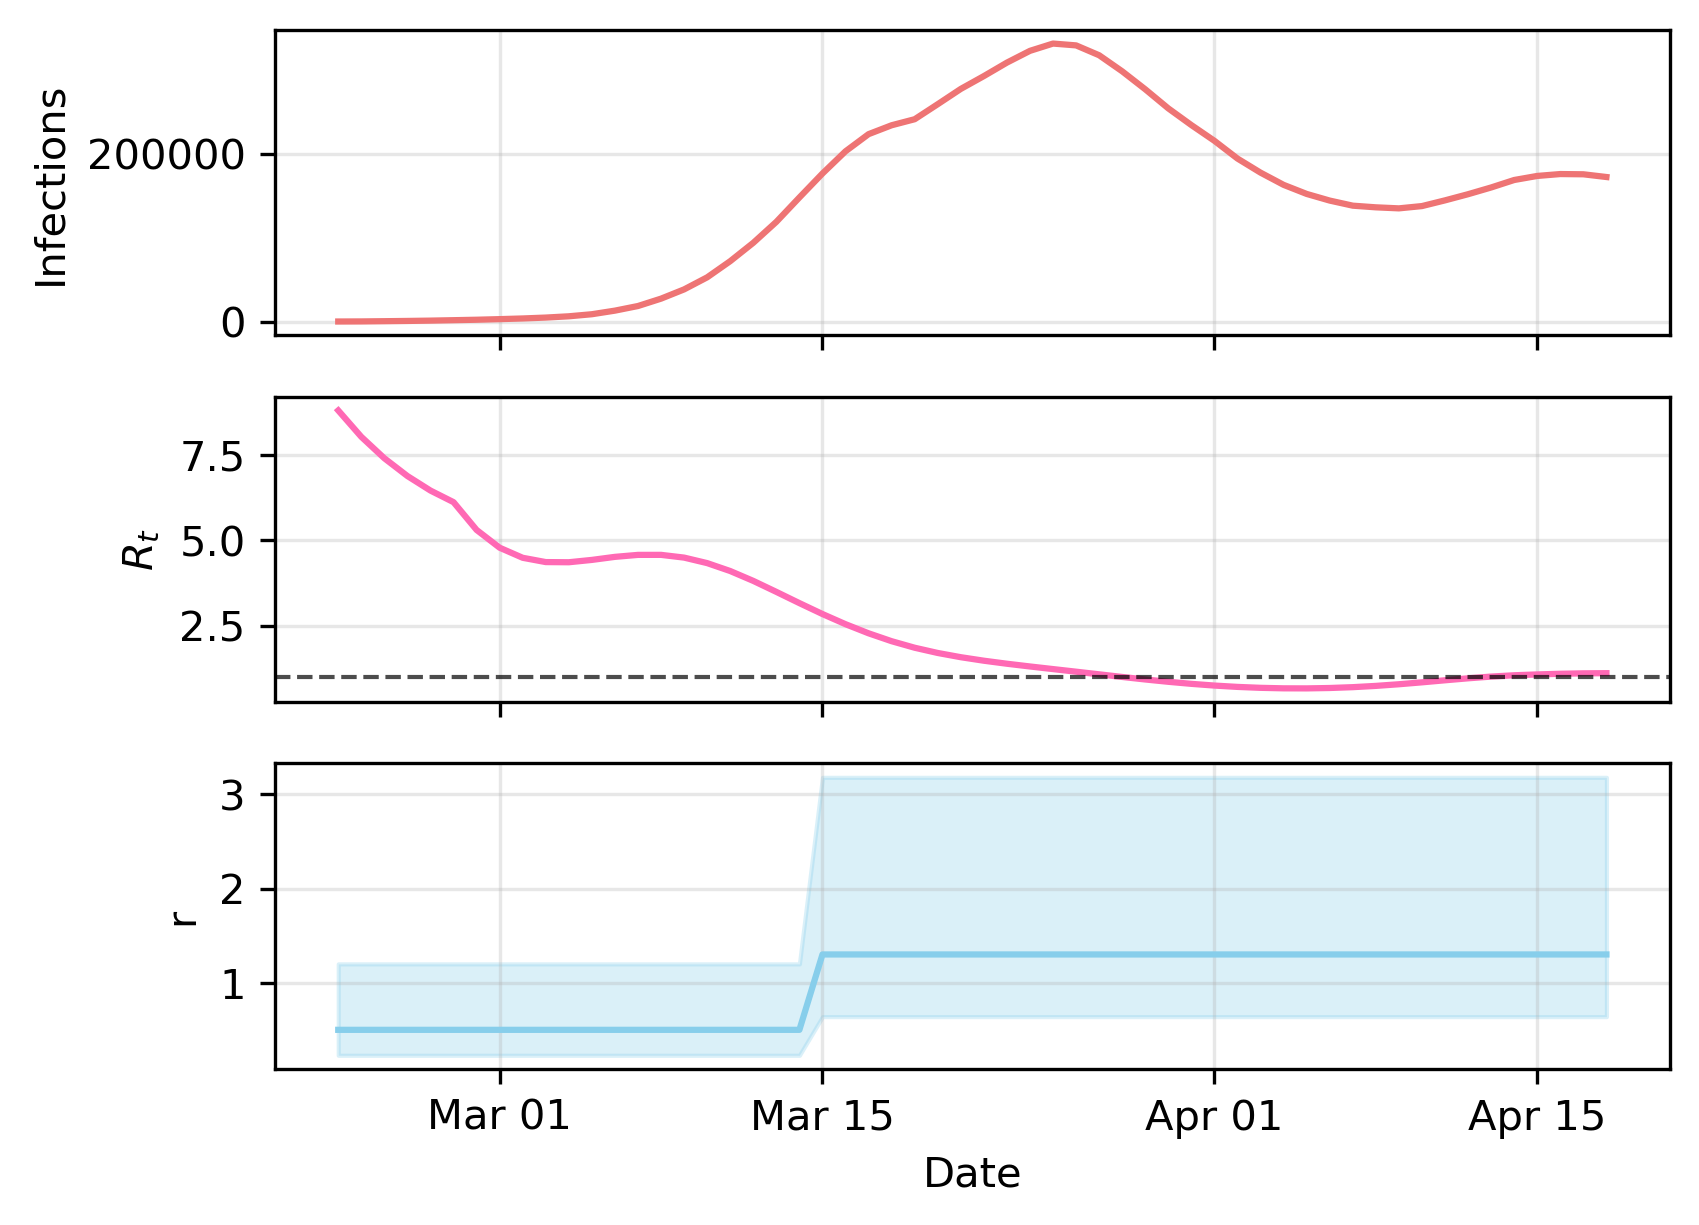

In [89]:
fig, axs = plt.subplots(3, 1, figsize=(6, 4.5), dpi=300, sharex=True)
# 1) Estimated infections
axs[0].plot(x, inf_plot, lw=1.5,c='#ee7474')
axs[0].set_ylabel('Infections')
axs[0].grid(True, alpha=0.3)

# # 2) Rt
axs[1].plot(x, Rt_plot, lw=1.5,c='#ff69b4')
axs[1].axhline(1.0, ls='--', lw=1, alpha=0.7,c='black')
axs[1].set_ylabel(r'$R_t$')
axs[1].grid(True, alpha=0.3)

# 3) r (dispersion)
axs[2].plot(x, r_array, lw=1.5,c='#87ceeb')
axs[2].fill_between(x, r_lower, r_upper, color='#87ceeb', alpha=0.3)
axs[2].set_ylabel('r')
axs[2].grid(True, alpha=0.3)
axs[2].set_xlabel('Date')

locator = mdates.AutoDateLocator(minticks=6, maxticks=8)
formatter = mdates.DateFormatter('%b %d')
axs[2].xaxis.set_major_locator(locator)
axs[2].xaxis.set_major_formatter(formatter)

plt.savefig('../results/real/inferred_real.png', dpi=300, bbox_inches='tight')

In [143]:
r_list = np.array([20, 10, 2.0, 1.0, 0.5, 0.2, 0.1, 0.05, 0.025, 5., 2.5  , 13.333,  3.333,  1.333,  0.667,  0.286,  0.133, 0.067,  0.033, 0.37, 7.4])

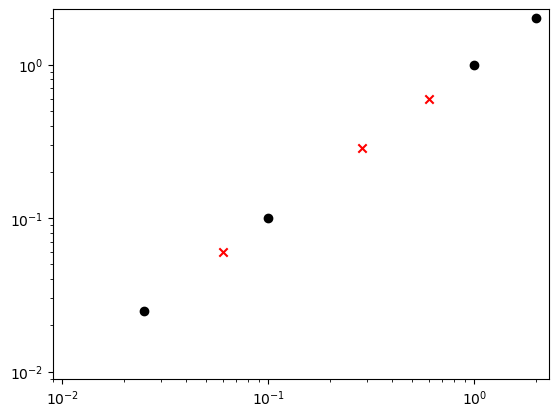

In [42]:

r_selected = np.array([0.025,0.1,1,2])
r_unused = np.array([0.6,0.06,0.286])
plt.scatter(r_selected, r_selected,c='black')
plt.scatter(r_unused, r_unused,c='red',marker='x')
plt.xlim(0.009,2.3)
plt.ylim(0.009,2.3)
plt.yscale('log')
plt.xscale('log')